1. Load the dataset

In [1]:
import pandas as pd

df = pd.read_csv('/content/london_weather.csv')

df.head()


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


2. Data Preprocessing

In [3]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


In [6]:
df = df.fillna(df.mean())


In [7]:
print("\nAfter filling missing values:")
print(df.isnull().sum())


After filling missing values:
date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64


In [12]:
df.head()


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


3. Normalize Data & Train-Test Split

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [13]:
data_values = df.drop(columns=['date']).values

In [14]:
#  Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_values)

In [15]:
# Define sequence length
SEQ_LENGTH = 7

# Prepare sequences and targets
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

X, y = create_sequences(data_normalized, SEQ_LENGTH)

4. Train Test Split

In [16]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (12267, 7, 9), y_train shape: (12267, 9)
X_test shape: (3067, 7, 9), y_test shape: (3067, 9)


5. RNN Model Development

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [18]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
# Define RNN Model
class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WeatherRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [21]:
# Model hyperparameters
input_size = 9
hidden_size = 64
num_layers = 2
output_size = 9

# Initialize model
model = WeatherRNN(input_size, hidden_size, num_layers, output_size)


In [22]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

WeatherRNN(
  (rnn): RNN(9, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)


6. Train the Model

In [23]:
# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0231
Epoch [2/20], Loss: 0.0141
Epoch [3/20], Loss: 0.0134
Epoch [4/20], Loss: 0.0128
Epoch [5/20], Loss: 0.0126
Epoch [6/20], Loss: 0.0123
Epoch [7/20], Loss: 0.0123
Epoch [8/20], Loss: 0.0122
Epoch [9/20], Loss: 0.0122
Epoch [10/20], Loss: 0.0121
Epoch [11/20], Loss: 0.0121
Epoch [12/20], Loss: 0.0121
Epoch [13/20], Loss: 0.0121
Epoch [14/20], Loss: 0.0121
Epoch [15/20], Loss: 0.0121
Epoch [16/20], Loss: 0.0120
Epoch [17/20], Loss: 0.0120
Epoch [18/20], Loss: 0.0120
Epoch [19/20], Loss: 0.0120
Epoch [20/20], Loss: 0.0119


7. Evaluation & Visualization

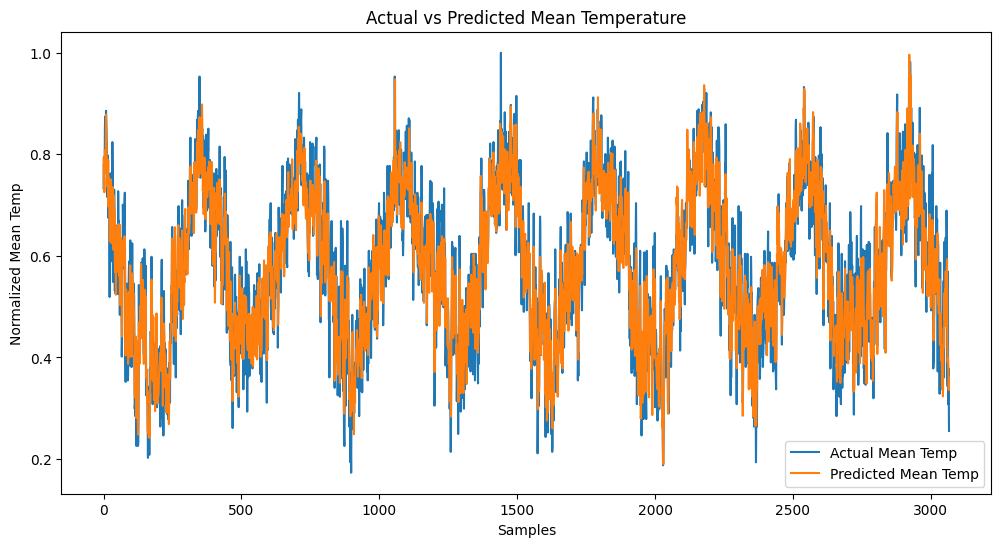

In [24]:
import matplotlib.pyplot as plt

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions.append(outputs.numpy())
        actuals.append(y_batch.numpy())

# Convert list to arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Plotting actual vs predicted for 'mean_temp' (feature index 5)
plt.figure(figsize=(12, 6))
plt.plot(actuals[:, 5], label='Actual Mean Temp')
plt.plot(predictions[:, 5], label='Predicted Mean Temp')
plt.xlabel('Samples')
plt.ylabel('Normalized Mean Temp')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Squared Error (MSE): 0.0134
Mean Absolute Error (MAE): 0.0712


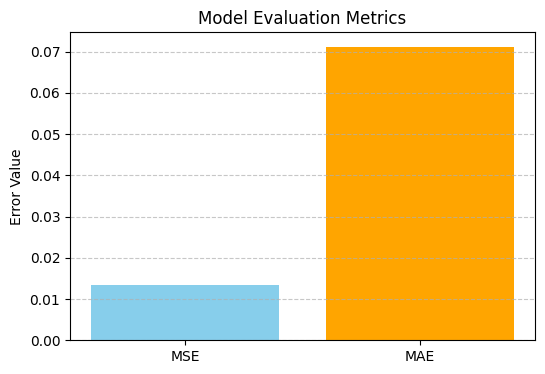

In [27]:
import matplotlib.pyplot as plt

metrics = ['MSE', 'MAE']
values = [mse, mae]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['skyblue', 'orange'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Error Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [25]:
# Save the model
torch.save(model.state_dict(), 'weather_rnn_model.pth')

import joblib
joblib.dump(scaler, 'scaler.save')

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


8. Testing

In [34]:
def predict_next_day(sample_sequence):
    """
    sample_sequence: numpy array of shape (7, 9) – normalized feature values
    """
    model.eval()
    with torch.no_grad():
        sample_tensor = torch.tensor(sample_sequence, dtype=torch.float32).unsqueeze(0)
        prediction = model(sample_tensor).numpy().flatten()

        prediction_denorm = scaler.inverse_transform([prediction])[0]

    return prediction, prediction_denorm

# Example usage
sample_input = X_test[0]
pred_norm, pred_denorm = predict_next_day(sample_input)

print("Predicted next day (normalized):", pred_norm)
print("\nPredicted next day (denormalized):", pred_denorm)


Predicted next day (normalized): [ 0.4876045   0.45372853  0.53980017  0.73085076  0.7787497   0.7918617
  0.00116611  0.699327   -0.00265671]

Predicted next day (denormalized): [ 4.38844049e+00  7.25965643e+00  2.20681266e+02  2.60305183e+01
  2.09022392e+01  1.52024844e+01  7.20657662e-02  1.02156037e+05
 -5.84476069e-02]


In [31]:
num_samples = 5

print(f"\nComparison of Actual vs Predicted outputs for {num_samples} samples:\n")

for i in range(num_samples):
    input_seq = X_test[i]
    actual = y_test[i]

    pred_norm, pred_denorm = predict_next_day(input_seq)

    # Denormalize actual for comparison
    actual_denorm = scaler.inverse_transform([actual])[0]

    print(f"Sample {i+1}:")
    print(f"Actual (denormalized):   {actual_denorm}")
    print(f"Predicted (denormalized): {pred_denorm}")
    print("-" * 80)



Comparison of Actual vs Predicted outputs for 5 samples:

Sample 1:
Actual (denormalized):   [1.0000e+00 1.1200e+01 2.6400e+02 2.6900e+01 1.9800e+01 1.3200e+01
 0.0000e+00 1.0257e+05 0.0000e+00]
Predicted (denormalized): [ 4.38844049e+00  7.25965643e+00  2.20681266e+02  2.60305183e+01
  2.09022392e+01  1.52024844e+01  7.20657662e-02  1.02156037e+05
 -5.84476069e-02]
--------------------------------------------------------------------------------
Sample 2:
Actual (denormalized):   [2.0000e+00 1.0500e+01 2.5400e+02 2.4100e+01 2.0900e+01 1.4800e+01
 0.0000e+00 1.0259e+05 0.0000e+00]
Predicted (denormalized): [ 2.80758056e+00  9.23137665e+00  2.45441253e+02  2.61208043e+01
  2.02607734e+01  1.37369655e+01 -8.00097468e-01  1.02314495e+05
 -1.16249725e-01]
--------------------------------------------------------------------------------
Sample 3:
Actual (denormalized):   [1.0000e+00 1.0000e+01 2.4700e+02 2.6900e+01 1.9400e+01 1.4700e+01
 0.0000e+00 1.0205e+05 0.0000e+00]
Predicted (denormali